In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/Users/willwolf/Documents/willwolf/dotify


In [4]:
# delete this eventually

import os

os.environ['SQLALCHEMY_DATABASE_URI'] = os.environ['DIGITAL_OCEAN_SQLALCHEMY_DATABASE_URI']

In [100]:
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from sqlalchemy import create_engine

from dotify.config import DevelopmentConfig as Config
from dotify.recommendation.implicit_mf.ratings_matrix import RatingsMatrix
from dotify.recommendation.implicit_mf.implicit_mf import ImplicitMF

ENGINE = create_engine(Config.SQLALCHEMY_DATABASE_URI)

%matplotlib inline

In [ ]:
# def save_array(file_name, array):
#     c_array = bcolz.carray(array, rootdir=file_name, mode='w')
#     c_array.flush()


# def load_array(file_name):
#     return bcolz.open(file_name)[:]

In [7]:
ratings_matrix = RatingsMatrix(n_top_songs=10000)

In [11]:
F = 30
ALPHA = 1
LAMBDA = 25

In [18]:
implicit_mf = ImplicitMF(ratings_matrix=RatingsMatrix(), f=F, alpha=ALPHA, lmbda=LAMBDA)

In [19]:
print(implicit_mf.country_vectors.vectors.shape)
print(implicit_mf.song_vectors.vectors.shape)

(55, 30)
(25357, 30)


In [20]:
implicit_mf.run()

0
1
2
3
4
5
6
7
8
9


In [114]:
# implicit_mf.country_vectors.vectors.to_csv('data/country_vectors.csv')
# implicit_mf.song_vectors.vectors.to_csv('data/song_vectors.csv')
implicit_mf.country_vectors.vectors = pd.read_csv('data/country_vectors.csv', index_col=['country_id'])
implicit_mf.song_vectors.vectors = pd.read_csv('data/song_vectors.csv', index_col=['song_id'])

In [ ]:
# inspect results

## Visualize

In [111]:
implicit_mf.country_vectors.vectors.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29
country_name,,,,,,,,,,,,,,,,,,,,,
United States,1.199533,0.805071,-1.701547,1.053904,0.507967,-0.842553,-0.700260,-1.435701,0.220028,-0.047097,...,2.310619,1.289404,-0.493658,0.185296,-0.611855,-2.279349,-1.221629,-2.486846,-1.509292,0.634107
United Kingdom,1.657513,1.186152,1.109628,-0.539622,0.308465,-0.425653,-1.427701,-0.964977,1.845865,-1.449298,...,-0.198157,1.489509,-2.361668,0.528493,2.023884,-0.809309,0.466260,0.797203,-0.102998,0.774133
Argentina,-0.361324,0.715569,0.095872,-0.763642,0.500045,-0.622255,0.453800,-1.494433,1.056581,0.578316,...,-0.842486,1.196757,0.780113,-1.784573,1.788248,0.490548,-1.354775,-0.643397,-0.199454,0.611466
Australia,0.922620,0.629252,-1.982874,-1.084756,-2.172330,-2.105921,-0.152939,0.699596,0.577632,1.760455,...,-0.363781,0.365383,-1.395616,-0.465801,-0.865641,-0.234164,0.291409,0.233215,-0.346712,1.232901
Austria,0.227114,0.694578,-0.146239,2.021938,0.581785,-0.909703,-1.525334,1.014610,-0.052186,-0.894440,...,-0.833079,-2.148726,-1.320359,-0.905628,0.571474,-1.350109,-0.591159,0.548953,-0.458362,0.062614


In [24]:
implicit_mf.song_vectors.vectors.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29
song_id,,,,,,,,,,,,,,,,,,,,,
5552,-0.077041,0.108355,-0.097699,0.155515,-0.095229,0.078845,-0.051036,-0.005292,0.169841,-0.083281,...,0.023157,0.072248,0.099295,0.005338,0.044581,-0.039196,-0.018968,-0.069020,0.029930,0.157775
5553,-0.094339,0.091163,-0.075031,0.210590,-0.134693,0.045414,-0.022887,0.001569,0.086351,-0.053027,...,0.024979,0.081063,0.119719,-0.000729,0.131279,-0.077077,-0.002516,-0.073528,0.046118,0.190829
5554,-0.090403,0.091216,-0.074708,0.208312,-0.132058,0.045682,-0.024401,0.001036,0.088304,-0.052268,...,0.023591,0.081062,0.116875,-0.003208,0.128440,-0.076629,-0.004486,-0.072347,0.043577,0.188794
5555,-0.082978,0.089974,-0.073077,0.204956,-0.128832,0.044359,-0.025805,0.000604,0.089665,-0.050472,...,0.021601,0.079641,0.112784,-0.008778,0.125857,-0.076733,-0.007947,-0.070830,0.039305,0.186027
5556,-0.082901,0.090079,-0.073140,0.204917,-0.128711,0.044592,-0.026017,0.000638,0.089910,-0.050329,...,0.021550,0.079760,0.112631,-0.008716,0.125574,-0.076613,-0.008091,-0.070707,0.039274,0.185886


In [25]:
sns.set(style="white")

In [119]:
from dotify.resources.countries import countries as countries_lookup


country_id_to_name = {countries_lookup[name]['id']: name for name in countries_lookup}


def replace_country_id_index_with_country_names(df):
    country_ids = df.index
    df.index = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
    return df


def plot_cosine_similarities(countries_df):
    
    country_ids = countries_df.index
    country_names = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')

    # compute the cosine similarity matrix
    similarities_df = pd.DataFrame(
        data=cosine_similarity(countries_df),
        index=country_names,
        columns=country_names
    )
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(similarities_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(21, 21))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(similarities_df, mask=mask, cmap=cmap, vmax=.5,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=1, cbar_kws={"shrink": .5}, ax=ax)

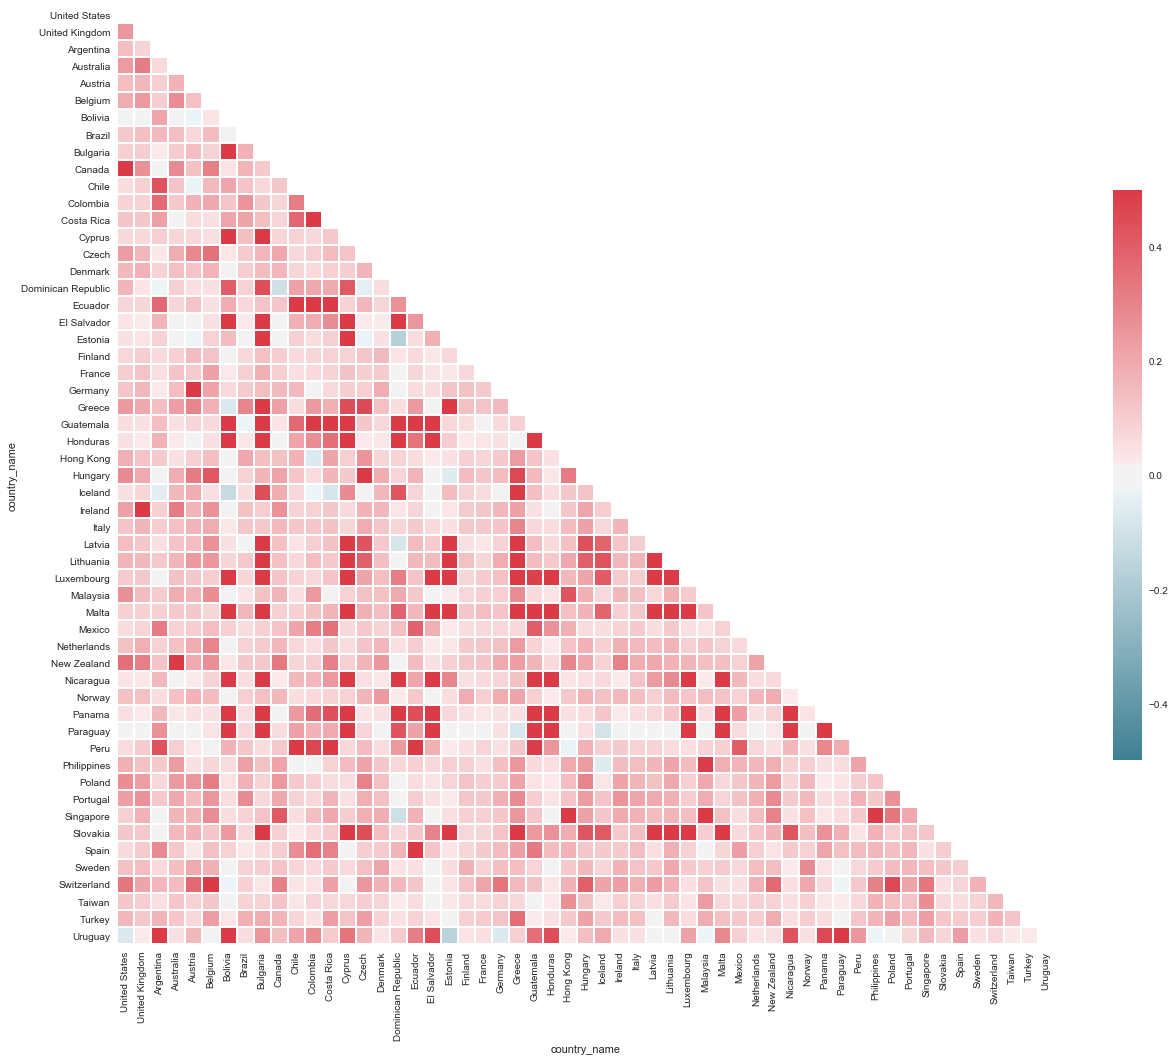

In [120]:
plot_cosine_similarities(implicit_mf.country_vectors.vectors)

## Inspect arithmetic combinations

In [221]:
SONG_VECTORS_QUERY = """
    SELECT 
        songs.title as song_title, 
        songs.artist as song_artist,
        song_vectors.* 
    FROM song_vectors 
    JOIN songs ON songs.id = song_vectors.song_id
"""

song_vectors_df = pd.read_sql(SONG_VECTORS_QUERY, ENGINE, index_col=['song_title', 'song_artist'])
song_vectors_df.drop('song_id', axis=1, inplace=True)

In [236]:
country_vec = country_vectors_df.ix['United States']

In [237]:
song_vectors_df.apply(lambda vec: np.dot(vec, country_vec), axis=1).sort_values(ascending=False).head(10)

song_title                                  song_artist  
In My Room (feat. Ty Dolla $ign & Tyga)     Yellow Claw      0.991541
The Fix                                     Nelly            0.988803
We Don't Talk Anymore (feat. Selena Gomez)  Charlie Puth     0.988479
Often                                       The Weeknd       0.988300
Wild Things                                 Alessia Cara     0.987689
Everyday                                    A$AP Rocky       0.987547
Exchange                                    Bryson Tiller    0.987494
Ophelia                                     The Lumineers    0.986675
Antidote                                    Travi$ Scott     0.986539
Love Yourself                               Justin Bieber    0.986213
dtype: float64